In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
import itertools

warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(y_scores,p, r, thresholds, t= 0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    
    # plot the curve
    sns.set()
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.00])
    plt.xlim([0.0, 1.00])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)



In [3]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [4]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# remove outliers:
print(len(df))
pU, pL = np.percentile(df['?TourGeneration'], [99.85 ,0.15])
df = df.loc[df['?TourGeneration'] <= (pU)]
df = df.loc[df['?TourGeneration'] >= (pL)]
print(len(df))
pU, pL = np.percentile(df['TourContractGeneration'], [99.85 ,0.15])
df = df.loc[df['TourContractGeneration'] <= (pU)]
df = df.loc[df['TourContractGeneration'] >= (pL)]
print(len(df))

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}
dic1 = {'Yes':1,'No':0}
dic2 = {'In State':1,'Out of State':0}
dic3 = {'Owner':1,'1st Gen':0}
dic4 = {'Couple':1,'Single':0}
dic5 = {'Weekday':0, 'Weekend':1}
dic6 = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
dic7 = {2016:0, 2017:1, 2018:2}

# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)
df['Homeowner']=df['Homeowner'].replace(dic1)
df['InState']=df['InState'].replace(dic2)
df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)
df['relationStatus']=df['relationStatus'].replace(dic4)
df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)
df['Month of TourDate']=df['Month of TourDate'].replace(dic6)
df['Year of TourDate']=df['Year of TourDate'].replace(dic7)

print(df.info())

25777
25746
25710
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25710 entries, 109662 to 385812
Data columns (total 17 columns):
?TourGeneration               25710 non-null int64
Age                           25710 non-null int64
AgentLine                     25710 non-null object
BookingWindow                 25710 non-null object
FirstGenVsOwner               25710 non-null int64
HHIncomeRanges                25710 non-null object
Homeowner                     25710 non-null int64
InState                       25710 non-null int64
Month of TourDate             25710 non-null int64
Programs (Budget)             25710 non-null object
relationStatus                25710 non-null int64
ResultOfTour                  25710 non-null int64
TourContractGeneration        25710 non-null int64
TourSeason                    25710 non-null object
WeekdayOrWeekend              25710 non-null int64
Year of TourDate              25710 non-null int64
NetVolumePlusNonGoodVolume    25710 non-null f

In [5]:
dfX = df.drop(['ResultOfTour',  'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=[ 'AgentLine','BookingWindow', 'HHIncomeRanges', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])     


scaler2 = StandardScaler()
scaler2.fit(dfX[['TourContractGeneration']])
dfX['TourContractGeneration'] = scaler2.transform(dfX[['TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])


X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)

dfX1 = X_train
dfY1 = y_train
 
print(dfX1.info())

resample = SMOTEENN(random_state=42)
dfX2, dfY2 = resample.fit_sample(dfX1, dfY1)
dfX2= pd.DataFrame(dfX2, columns = dfX.columns)
dfY2= pd.DataFrame(dfY2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20568 entries, 341314 to 331921
Data columns (total 43 columns):
?TourGeneration                                20568 non-null float64
Age                                            20568 non-null float64
FirstGenVsOwner                                20568 non-null int64
Homeowner                                      20568 non-null int64
InState                                        20568 non-null int64
Month of TourDate                              20568 non-null int64
relationStatus                                 20568 non-null int64
TourContractGeneration                         20568 non-null float64
WeekdayOrWeekend                               20568 non-null int64
Year of TourDate                               20568 non-null int64
AgentLine_Breck                                20568 non-null uint8
AgentLine_Colorado                             20568 non-null uint8
AgentLine_Other Line                           20568 non-null u

In [6]:
bestC = 0
bestTLR = 0
bestF1LR = 0
bestF1C = 0
bestCMLR = pd.DataFrame()
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,50]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrainResample,yTrainResample = resample.fit_sample(xTrain,yTrain)
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    lr = LogisticRegression(C=Cs[i], fit_intercept=False)
    lr.fit(xTrainResample,yTrainResample)
    preds = lr.predict_proba(xTest)[:,1]
    for j in preds:
        predT = adjusted_classes(preds, j)
        f1 = metrics.fbeta_score(yTest, predT,average='binary',beta=2)
        if f1>bestF1LR:
            bestC=Cs[i]
            bestF1LR=f1
            bestTLR= j
            bestCMLR =pd.DataFrame(confusion_matrix(yTest, predT),
                                columns=['pred_neg', 'pred_pos'], 
                                index=['neg', 'pos'])
    i += 1
    
print(bestC)
print(bestTLR)
print(bestF1LR)
print(bestCMLR)

50
0.3908556385456615
0.5588413709432818
     pred_neg  pred_pos
neg       581      2757
pos        38       737


In [7]:
bestL = 0
bestTRFC = 0
bestF1RFC = 0
bestCMRFC = pd.DataFrame()
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Ls = [1,20,40, 80,100]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrainResample,yTrainResample = resample.fit_sample(xTrain,yTrain)
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    rfc = RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_leaf =Ls[i])
    rfc.fit(xTrainResample,yTrainResample)
    preds = rfc.predict_proba(xTest)[:,1]
    for j in preds:
        predT = adjusted_classes(preds, j)
        f1 = metrics.fbeta_score(yTest, predT,average='binary', beta =2)
        if f1>bestF1RFC:
            bestL=Ls[i]
            bestF1RFC=f1
            bestTRFC= j
            bestCMRFC = pd.DataFrame(confusion_matrix(yTest, predT),
                                columns=['pred_neg', 'pred_pos'], 
                                index=['neg', 'pos'])
    i += 1
    
print(bestL)
print(bestTRFC)
print(bestF1RFC)
print(bestCMRFC)

100
0.4003125704942545
0.5522682445759368
     pred_neg  pred_pos
neg       575      2763
pos        47       728


In [8]:


bestCMHL = pd.DataFrame()
bestHL = 0
bestF1HL = 0
bestTHL =0
i = 0

#make cross validation of c values and kfold
HLs= [x for x in itertools.product((2,4,10,15,20),repeat=1)]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrainResample,yTrainResample = resample.fit_sample(xTrain,yTrain)
    xTest = dfX1.iloc[test.tolist()]
    yTest = dfY1.iloc[test.tolist()]
    mlp = MLPClassifier(hidden_layer_sizes=HLs[i])
    mlp.fit(xTrainResample,yTrainResample)
    preds = mlp.predict_proba(xTest)[:,1]
    for j in preds:
        predT = adjusted_classes(preds, j)
        f1 = metrics.fbeta_score(yTest, predT,beta=2,average='binary')
        if f1>bestF1HL:
            bestHL=HLs[i]
            bestF1HL=f1
            bestTHL= j
            bestCMHL = pd.DataFrame(confusion_matrix(yTest, predT),
                                columns=['pred_neg', 'pred_pos'], 
                                index=['neg', 'pos'])
    i += 1

print(bestHL)
print(bestTHL)
print(bestF1HL)
print(bestCMHL)

(4,)
0.40619753039450535
0.5598484848484849
     pred_neg  pred_pos
neg       581      2757
pos        37       739


Logistic Regression Threshold: 0.3908556385456615
     pred_neg  pred_pos
neg       699      3473
pos        53       917
Best F2 Score:  0.554


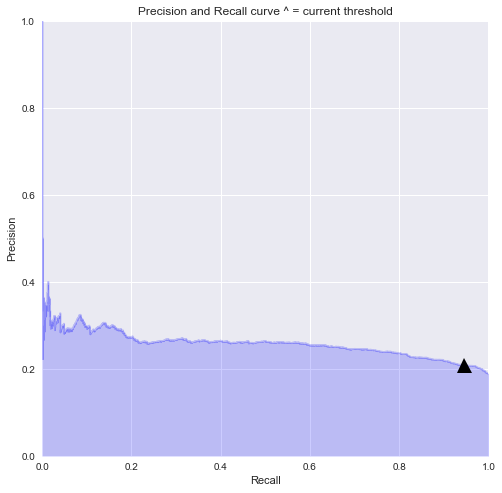

In [9]:
lr= LogisticRegression(C = bestC, fit_intercept=False)
lr.fit(dfX2,dfY2)
y_scores = lr.predict_proba(X_test)[:, 1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTLR)
y_scores = adjusted_classes(y_scores,bestTLR)
print('Logistic Regression Threshold:',str(bestTLR))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print('Best F2 Score: ',str(round(metrics.fbeta_score(y_test,y_scores,average='binary',beta =2),3)))

Random Forest Threshold: 0.4003125704942545
     pred_neg  pred_pos
neg       762      3410
pos        67       903
Best F2 Score:  0.551


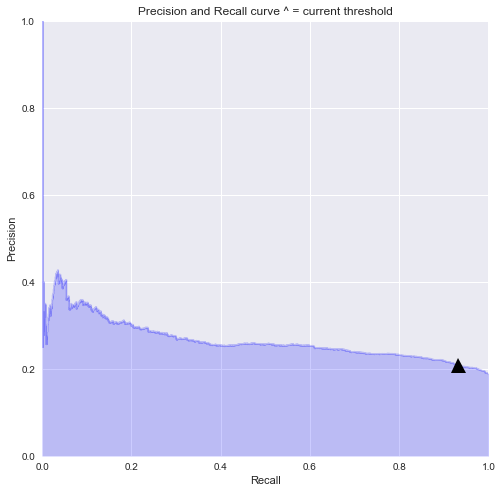

In [10]:
rf= RandomForestClassifier(n_estimators=1000, random_state=42, min_samples_leaf =bestL)
rf.fit(dfX2,dfY2)
y_scores = rf.predict_proba(X_test)[:, 1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTRFC)
y_scores = adjusted_classes(y_scores,bestTRFC)
print('Random Forest Threshold:',str(bestTRFC))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print('Best F2 Score: ',str(round(metrics.fbeta_score(y_test,y_scores,average='binary',beta =2),3)))

MLP Best Threshold: 0.40619753039450535
     pred_neg  pred_pos
neg       878      3294
pos        82       888
Best F2 Score:  0.551


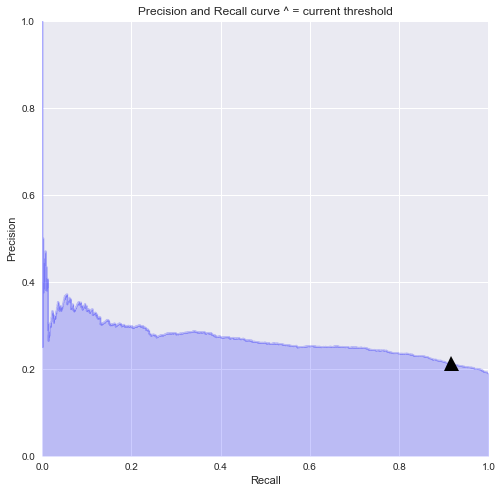

In [11]:
mlp = MLPClassifier(hidden_layer_sizes=bestHL)
mlp.fit(dfX2,dfY2)
y_scores = mlp.predict_proba(X_test)[:,1]
p,r,threshold = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(y_scores ,p, r, threshold, bestTHL)
y_scores = adjusted_classes(y_scores,bestTHL)
print('MLP Best Threshold:',str(bestTHL))
print(pd.DataFrame(confusion_matrix(y_test, y_scores),
                    columns=['pred_neg', 'pred_pos'], 
                    index=['neg', 'pos']))
print('Best F2 Score: ',str(round(metrics.fbeta_score(y_test,y_scores,average='binary',beta =2),3)))

In [12]:
for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(round(x,3),y)

0.153 InState
0.103 ?TourGeneration
0.096 HHIncomeRanges_70k to 89k
0.093 TourContractGeneration
0.07 FirstGenVsOwner
0.062 Age
0.053 WeekdayOrWeekend
0.044 relationStatus
0.026 Year of TourDate
0.025 HHIncomeRanges_90k to 149k
0.024 HHIncomeRanges_150k to 199k
0.022 Programs (Budget)_(09) GL7 Inhouse
0.022 AgentLine_Colorado
0.018 HHIncomeRanges_200k to 349k
0.018 Programs (Budget)_(12) Outbound Telemarktng
0.018 AgentLine_Breck
0.017 HHIncomeRanges_Under 70k
0.016 Month of TourDate
0.014 BookingWindow_Inside 2 Days
0.013 Homeowner
0.013 BookingWindow_Inside 90 days
0.013 Programs (Budget)_(21) GTL In House
0.009 BookingWindow_Inside Week
0.008 BookingWindow_Inside Month
0.007 Programs (Budget)_(15) Internet
0.005 HHIncomeRanges_350k to 500k
0.005 BookingWindow_Inside Half Year
0.005 TourSeason_Spring
0.005 Programs (Budget)_(24) Front Range Events
0.004 Programs (Budget)_(06) GC8 Inhouse
0.004 BookingWindow_Inside Year
0.003 Programs (Budget)_(14) Summit County OPC
0.003 TourSeason_W